<a href="https://colab.research.google.com/github/abhiWriteCode/Small-Machine-Learning-Projects/blob/master/CIFAR10_using_pytorch%202nd%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install 'torch==0.4.0'
!pip3 install 'torchvision==0.2.1'
!pip3 install --no-cache-dir -I 'pillow==5.1.0'
!pip install torchsummary


# Restart Kernel
# This workaround is needed to properly upgrade PIL on Google Colab.
import os
os._exit(00)

    100% |████████████████████████████████| 2.0MB 50.3MB/s 


In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms
%matplotlib inline

In [2]:
mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
batch_size = 8

transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


transform_test = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize(mean, std)])

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.imshow(img.transpose((1, 2, 0)))
    plt.show()

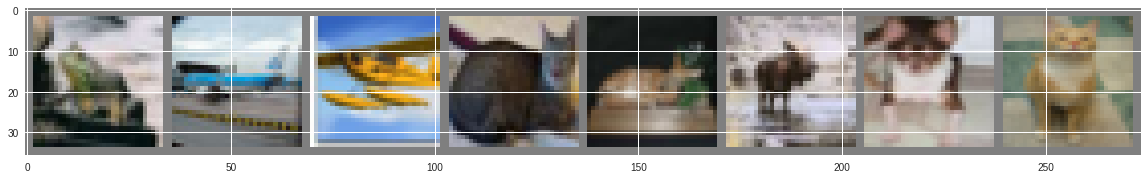

 frog plane plane   cat  deer  deer   dog   cat


In [4]:
# show images
plt.figure(figsize=(20,6))
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [0]:
import torch.nn as nn
import torch.nn.functional  as F

class Network2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
        
model = Network2()

In [29]:
images.shape

torch.Size([8, 3, 32, 32])

In [0]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

if device:
  print('Thanks google')
  model.to(device)

cuda
Thanks google


In [33]:
from torchsummary import summary

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
Total params: 61,156
Trainable params: 61,156
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [34]:
model.fc1.weight

Parameter containing:
tensor(1.00000e-02 *
       [[-3.9326, -1.1735,  4.4007,  ..., -2.3170, -0.3754, -0.0118],
        [-0.9681, -2.6195,  1.5723,  ..., -0.9056,  1.5288,  3.1502],
        [ 4.6651, -2.5402,  3.8858,  ...,  0.1611,  0.7448,  0.3176],
        ...,
        [ 0.0865, -1.0139, -3.8900,  ...,  3.1020, -3.1133, -0.9085],
        [ 4.7380,  3.2803, -2.2408,  ...,  2.3402,  4.8325, -4.8477],
        [-4.4386,  2.5954,  1.9988,  ...,  1.3450, -2.6530, -1.1141]], device='cuda:0')

In [0]:
def train(epochs=20):
  print('Training started')
  train_losses, test_losses = [], []
    
  for e in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:

      if device:
        images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()

      log_ps = model(images)
      loss = criterion(log_ps, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    else:
      test_loss = 0
      accuracy = 0

      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():
        model.eval()
        for images, labels in testloader:
          
          if device:
            images, labels = images.to(device), labels.to(device)
            
          log_ps = model(images)
          test_loss += criterion(log_ps, labels)

          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.cuda.FloatTensor))

      model.train()

      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(testloader))

      print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
            "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
            "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
      
  print('Finished training')
  return train_losses, test_losses

In [36]:
%%time
train_losses, test_losses = train(epochs=10)

Training started
Epoch: 1/10..  Training Loss: 2.260..  Test Loss: 1.594..  Test Accuracy: 0.422
Epoch: 2/10..  Training Loss: 1.494..  Test Loss: 1.416..  Test Accuracy: 0.488
Epoch: 3/10..  Training Loss: 1.348..  Test Loss: 1.246..  Test Accuracy: 0.554
Epoch: 4/10..  Training Loss: 1.244..  Test Loss: 1.174..  Test Accuracy: 0.583
Epoch: 5/10..  Training Loss: 1.167..  Test Loss: 1.151..  Test Accuracy: 0.592
Epoch: 6/10..  Training Loss: 1.109..  Test Loss: 1.123..  Test Accuracy: 0.605
Epoch: 7/10..  Training Loss: 1.070..  Test Loss: 1.055..  Test Accuracy: 0.631
Epoch: 8/10..  Training Loss: 1.028..  Test Loss: 1.068..  Test Accuracy: 0.624
Epoch: 9/10..  Training Loss: 1.001..  Test Loss: 1.048..  Test Accuracy: 0.634
Epoch: 10/10..  Training Loss: 0.972..  Test Loss: 0.994..  Test Accuracy: 0.652
Finished training
CPU times: user 4min 49s, sys: 1min 20s, total: 6min 9s
Wall time: 7min 1s


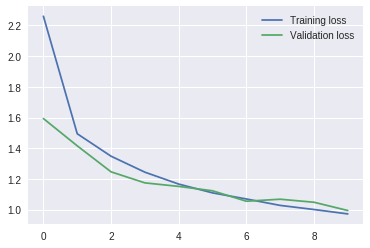

In [37]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

plt.show()

In [43]:
for i in model.parameters():
  print(i.shape)

torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])
